
Test Accuracy (Random Forest): 88.87%
Classification Report (Random Forest):
                 precision    recall  f1-score   support

      Positive       0.88      0.92      0.90       313
      Negative       0.89      0.93      0.91       307
  Not_relevant       0.83      0.72      0.77       311
Mixed Feelings       0.99      1.00      1.00       343
       Neutral       0.83      0.86      0.84       298

      accuracy                           0.89      1572
     macro avg       0.88      0.89      0.88      1572
  weighted avg       0.89      0.89      0.89      1572



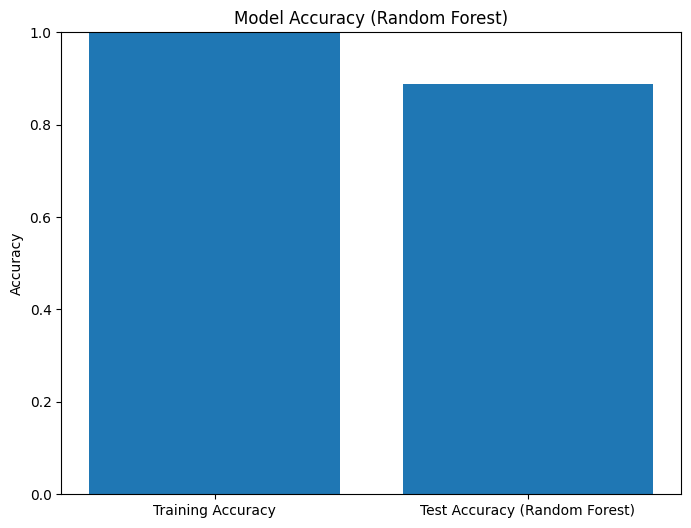

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load data from CSV
file_path = 'final_manglish_emoji.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['commentText'] = data['commentText'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and word embedding using Word2Vec
sentences = [text.split() for text in data['commentText']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

# Function to convert text data to Word2Vec embeddings
def text_to_vector(text):
    words = text.split()
    vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

X = np.vstack([text_to_vector(text) for text in data['commentText']])
y = data['Sentiment_Class']

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']],
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Convert upsampled text data to Word2Vec embeddings
upsampled_sentences = [text.split() for text in data_upsampled['commentText']]
X_upsampled = np.vstack([text_to_vector(text) for text in data_upsampled['commentText']])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.05, random_state=40)

# Build and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model on test data
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nTest Accuracy (Random Forest): {accuracy_rf * 100:.2f}%")

# Generate predictions for Random Forest
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_pred_labels_rf = [reverse_sentiment_dict[label] for label in y_pred_rf]

# Print complete classification report for Random Forest
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf, target_names=sentiment_dict.keys()))

# Plotting the accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Training Accuracy', 'Test Accuracy (Random Forest)'], [accuracy_score(y_train, rf_model.predict(X_train)), accuracy_rf])
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Random Forest)')
plt.ylim(0, 1)
plt.show()
